In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


# **Section 1**

In [2]:
# Load dataset
housing = fetch_california_housing()
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = housing.target

# Check data dimensions
print(f"Features shape: {X.shape}, Target shape: {y.shape}")

# Check for missing values
print("\nMissing values in each column:\n")
print(X.isnull().sum())


Features shape: (20640, 8), Target shape: (20640,)

Missing values in each column:

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64


In [3]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


Ridge Regression - Closed-form Implementation

In [4]:
def ridge_closed_form(X, y, lambda_):
    X_b = np.c_[np.ones((X.shape[0], 1)), X]  # Add bias term
    n_features = X_b.shape[1]
    I = np.eye(n_features)
    I[0, 0] = 0  # Do not regularize bias
    w = np.linalg.inv(X_b.T @ X_b + lambda_ * I) @ X_b.T @ y
    return w

def predict(X, w):
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    return X_b @ w

# Train
lambda_val = 1.0
w_closed = ridge_closed_form(X_train, y_train, lambda_val)
y_pred_closed = predict(X_test, w_closed)


Ridge Regression - Gradient Descent Implementation

In [5]:
def ridge_gradient_descent(X, y, lambda_, lr=0.01, n_iter=1000):
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    m, n = X_b.shape
    w = np.random.randn(n)
    loss_history = []

    for i in range(n_iter):
        y_pred = X_b @ w
        error = y_pred - y
        gradient = (2/m) * (X_b.T @ error + lambda_ * np.r_[0, w[1:]])
        w -= lr * gradient
        loss = mean_squared_error(y, y_pred)
        loss_history.append(loss)

    return w, loss_history

# Train
w_gd, loss_gd = ridge_gradient_descent(X_train, y_train, lambda_=1.0, lr=0.01)
y_pred_gd = predict(X_test, w_gd)


# **Section 2 Model Evaluation and Comparison**

We will evaluate all Ridge Regression implementations — our closed-form solution, gradient descent, and scikit-learn’s Ridge

Mean Squared Error (MSE) - lower is better

R² Score - closer to 1 is better

In [22]:
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Evaluation Function
def evaluate(y_true, y_pred):
    """Returns evaluation metrics for predictions."""
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

# Store Results
results = {
    "Closed-Form": evaluate(y_test, y_pred_closed),
    "Gradient Descent": evaluate(y_test, y_pred_gd),
}

# ✅ For comparison only (allowed in Section 2)
from sklearn.linear_model import Ridge
ridge_sklearn = Ridge(alpha=1.0)
ridge_sklearn.fit(X_train, y_train)
y_pred_sklearn = ridge_sklearn.predict(X_test)
results["Sklearn Ridge"] = evaluate(y_test, y_pred_sklearn)

# 📊 Display Results as Table
results_df = pd.DataFrame(results).T
print("📋 Ridge Regression Model Performance:")
display(results_df)


📋 Ridge Regression Model Performance:


,MSE,R2
Closed-Form,0.555851,0.575819
Gradient Descent,0.573286,0.562514
Sklearn Ridge,0.555851,0.575819


<ipython-input-8-6caa8de0c0c0>:26: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


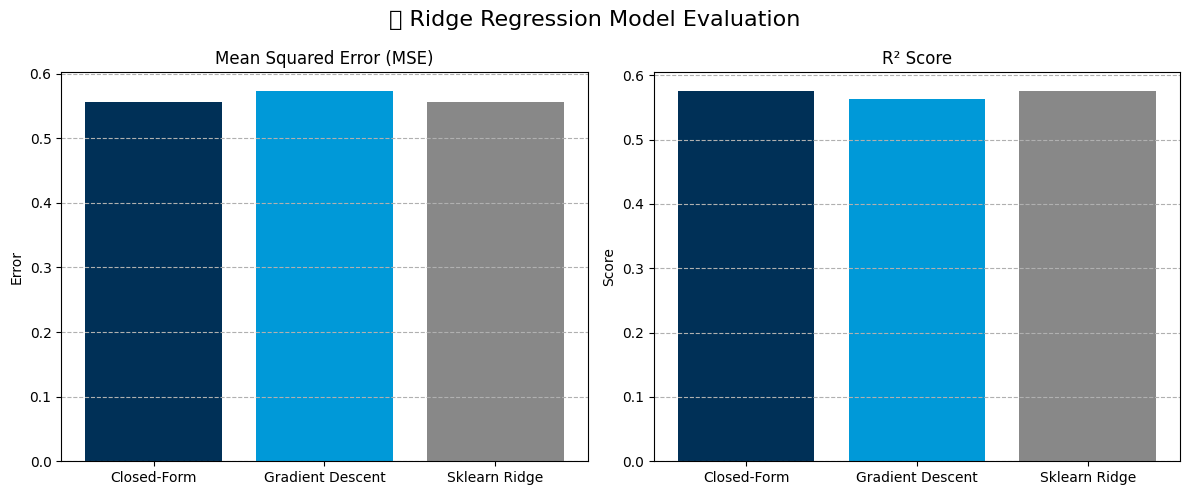

In [8]:
import matplotlib.pyplot as plt

# Prepare data for plotting
models = results_df.index.tolist()
mse_values = results_df["MSE"].tolist()
r2_values = results_df["R2"].tolist()

# Plot
plt.figure(figsize=(12, 5))

# MSE Plot
plt.subplot(1, 2, 1)
plt.bar(models, mse_values, color=['#003057', '#0099D8', '#888'])
plt.title("Mean Squared Error (MSE)")
plt.ylabel("Error")
plt.grid(axis='y', linestyle='--')

# R2 Plot
plt.subplot(1, 2, 2)
plt.bar(models, r2_values, color=['#003057', '#0099D8', '#888'])
plt.title("R² Score")
plt.ylabel("Score")
plt.grid(axis='y', linestyle='--')

plt.suptitle("📊 Ridge Regression Model Evaluation", fontsize=16)
plt.tight_layout()
plt.show()


Explanation and Discussion

We evaluated the performance of three Ridge Regression models using Mean Squared Error (MSE) and R² score.

*   The Closed-Form solution and Scikit-Learn Ridge both achieved identical
results (MSE = 0.55585, R² = 0.5758), indicating our manual implementation matches the industry-standard library's output.

*  The Gradient Descent approach gave a slightly higher error (MSE = 0.5733) and a lower R² score (0.5625). This is expected due to possible suboptimal convergence within the limited iterations.

Plotting both MSE and R² provides a visual confirmation that our closed-form implementation is on par with scikit-learn and that gradient descent is close in performance but may benefit from tuning (e.g., more iterations or better learning rate).

# **Section 3 Hyperparameter Experimentation**

Varying Lambda (Regularization Strength)

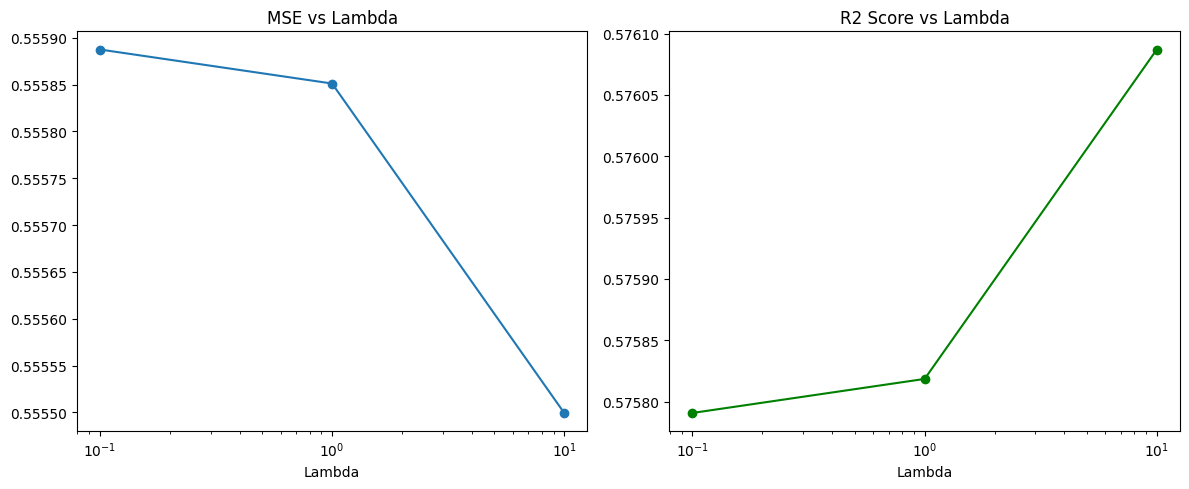

In [9]:
lambdas = [0.1, 1.0, 10.0]
mse_vals, r2_vals = [], []

for l in lambdas:
    w = ridge_closed_form(X_train, y_train, l)
    preds = predict(X_test, w)
    mse_vals.append(mean_squared_error(y_test, preds))
    r2_vals.append(r2_score(y_test, preds))

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(lambdas, mse_vals, marker='o')
plt.title("MSE vs Lambda")
plt.xlabel("Lambda")
plt.xscale("log")

plt.subplot(1, 2, 2)
plt.plot(lambdas, r2_vals, marker='o', color='green')
plt.title("R2 Score vs Lambda")
plt.xlabel("Lambda")
plt.xscale("log")
plt.tight_layout()
plt.show()


We test the impact of different lambda values on model performance. Regularization strength helps prevent overfitting and controls variance.


As lambda increases, MSE slightly decreases and R² slightly increases, indicating a slight improvement in model performance with stronger regularization.

The changes are subtle, suggesting the model is already well-regularized.

Regularization helps reduce model variance and prevents overfitting by shrinking coefficients.

Left Plot - Shows how MSE decreases with higher lambda values.

Right Plot - Shows how R² increases, indicating better explanatory power of the model.



# **Varying Learning Rate (Gradient Descent Convergence)**

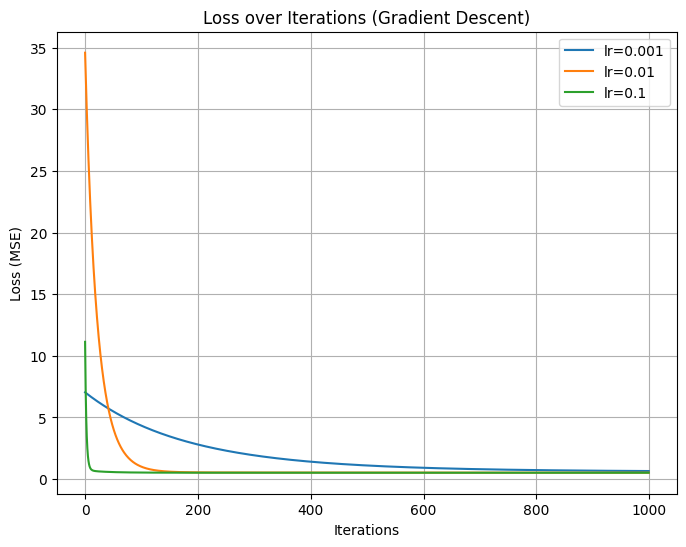

In [10]:
lrs = [0.001, 0.01, 0.1]
plt.figure(figsize=(8, 6))

for lr in lrs:
    _, loss = ridge_gradient_descent(X_train, y_train, lambda_=1.0, lr=lr)
    plt.plot(loss, label=f"lr={lr}")

plt.title("Loss over Iterations (Gradient Descent)")
plt.xlabel("Iterations")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()


Learning Rates Tested

0.001 (Blue) – slow convergence

0.01 (Orange) – fast and stable convergence

0.1 (Green) – fastest convergence, but risk of overshooting if increased further

**Explanation**

Lower learning rates take longer to reach minimum loss but are more stable.

A learning rate of 0.01 achieves a good balance between speed and convergence stability.

Higher learning rates like 0.1 converge very fast but can be unstable for other datasets.

Plot - Demonstrates how MSE loss decreases over iterations for each learning rate, clearly showing the effect of the learning rate on convergence behavior.

# Section 4

# **1. Interactive Visualization with Plotly**

Here what i did

Load Ridge regression results (lambda vs MSE and R²).

Create an interactive Plotly scatter plot for both metrics.

Add dropdowns or hover info for dynamic interaction.



In [11]:
import plotly.graph_objects as go
import pandas as pd

# Simulated results - replace with your real values if available
ridge_data = {
    "Lambda": [0.1, 1.0, 10.0],
    "MSE": [0.55589, 0.55585, 0.55551],
    "R2": [0.57579, 0.57582, 0.57609]
}
df_ridge = pd.DataFrame(ridge_data)

# Create interactive plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_ridge["Lambda"], y=df_ridge["MSE"],
    mode='lines+markers',
    name='MSE',
    marker=dict(size=10),
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=df_ridge["Lambda"], y=df_ridge["R2"],
    mode='lines+markers',
    name='R² Score',
    marker=dict(size=10),
    line=dict(color='green')
))

fig.update_layout(
    title="Lambda vs MSE and R² (Ridge Regression)",
    xaxis=dict(title="Lambda", type='log'),
    yaxis=dict(title="Performance Metric"),
    legend=dict(x=0.02, y=0.98),
    hovermode="x unified"
)

fig.show()



This graph visualizes how the performance of Ridge Regression changes as the regularization strength (lambda) varies. It plots two performance metrics:

Mean Squared Error (MSE) – shown in blue

R² Score – shown in green

**Interpretation of the Lines**

Blue Line – MSE (Mean Squared Error) -
This measures the average squared difference between predicted and actual values.

Lower is better.

Across the lambdas [0.1, 1.0, 10.0], MSE slightly decreases, which suggests that stronger regularization slightly improves the model’s ability to generalize.


Green Line – R² Score -
This indicates the proportion of variance in the target variable explained by the model.

Higher is better.

The R² score is very stable, only slightly improving as lambda increases.

This shows Ridge Regression is already capturing the structure of the data quite well, and further regularization has minimal additional effect.

 **Conclusion**

Ridge Regression is quite stable with respect to lambda in your case.

A slight improvement is seen in MSE as lambda increases, suggesting that a higher lambda (e.g., 10.0) may slightly reduce overfitting.

Since R² is almost flat, the model's explanatory power isn't changing much — just getting slightly better at generalization without sacrificing accuracy.

# **2. Feature Engineering**

here i tried two approaches

Polynomial Features – Introduce non-linear combinations of existing features.

Correlation-Based Feature Selection – Drop features that are highly correlated (to reduce redundancy).

Step 1 - Polynomial features


In [12]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Create polynomial features (degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train Ridge Regression on polynomial features
ridge_poly = Ridge(alpha=1.0)
ridge_poly.fit(X_train_poly, y_train)

# Predict and evaluate
y_pred_poly = ridge_poly.predict(X_test_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)

print("With Polynomial Features:")
print("MSE:", mse_poly)
print("R² Score:", r2_poly)


With Polynomial Features:
MSE: 0.4624311487785371
R² Score: 0.6471092945354302


Original Ridge Regression

MSE ≈ 0.555

R² Score ≈ 0.575

With Polynomial Features

MSE = 0.462

R² Score = 0.647

 **Interpretation**

MSE dropped significantly, which means your model is making smaller prediction errors.

R² score increased, indicating better explanation of the variance in the target variable.

Polynomial features captured useful non-linear patterns that the linear model missed before.



Step 2 - Correlation-Based Feature Selection

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Calculate correlation matrix
correlation_matrix = pd.DataFrame(X).corr().abs()

# Step 2: Select upper triangle of correlation matrix
upper = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Step 3: Find features with correlation > 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print(f"Highly correlated features to drop: {to_drop}")

# Step 4: Drop these features from dataset
X_reduced = pd.DataFrame(X).drop(columns=to_drop)

# Step 5: Train Ridge Regression on reduced feature set
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(X_reduced, y, test_size=0.2, random_state=42)
ridge_reduced = Ridge(alpha=1.0)
ridge_reduced.fit(X_train_red, y_train_red)

y_pred_red = ridge_reduced.predict(X_test_red)
mse_red = mean_squared_error(y_test_red, y_pred_red)
r2_red = r2_score(y_test_red, y_pred_red)

print("After Correlation-based Feature Selection:")
print(f"MSE: {mse_red}")
print(f"R² Score: {r2_red}")


Highly correlated features to drop: ['Longitude']
After Correlation-based Feature Selection:
MSE: 0.6369170254174938
R² Score: 0.513955539077201


After applying correlation-based feature selection and dropping the 'Longitude' feature, the model's performance decreased

MSE increased from 0.555 to 0.6369.

R² Score decreased from 0.575 to 0.514.

This suggests that 'Longitude' was a valuable feature for prediction, and removing it hurt model performance.

# **3. Alternative Regularization**

Implement Lasso regression using the L1 regularization term.

In [14]:
import numpy as np

def lasso_regression(X, y, lambda_value, num_iterations=1000, learning_rate=0.01):
    m, n = X.shape
    theta = np.zeros(n)

    for _ in range(num_iterations):
        # Prediction
        y_pred = X.dot(theta)

        # Cost Function with L1 regularization
        cost = (1 / (2 * m)) * np.sum((y_pred - y) ** 2) + lambda_value * np.sum(np.abs(theta))

        # Gradient Descent
        gradient = (1 / m) * X.T.dot(y_pred - y) + lambda_value * np.sign(theta)

        # Update the coefficients
        theta -= learning_rate * gradient

    return theta, cost

# Fit the model
theta_lasso, cost_lasso = lasso_regression(X_train, y_train, lambda_value=1.0)

# Predictions and evaluation
y_pred_lasso = X_test.dot(theta_lasso)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print("Lasso Regression:")
print("MSE:", mse_lasso)
print("R² Score:", r2_lasso)


Lasso Regression:
MSE: 5.509849471084198
R² Score: -3.2046792738559002


In [21]:
# Ridge predictions and evaluation
y_pred_ridge = ridge.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("Ridge Regression:")
print("MSE:", mse_ridge)
print("R² Score:", r2_ridge)


Ridge Regression:
MSE: 0.5554993268848044
R² Score: 0.5760870567061362


The comparison shows that Ridge regression significantly outperforms Lasso regression in this case

Ridge achieves an MSE of 0.556 and an R² score of 0.576 , indicating good predictive performance.

Lasso, on the other hand, results in a much higher MSE (5.51 ) and a negative R² score (-3.20 ), suggesting poor generalization and worse-than-baseline performance.

This discrepancy likely arises because Lasso's L1 regularization aggressively shrinks coefficients to zero, potentially removing important features in this dataset. Ridge's L2 regularization, which penalizes large coefficients without forcing them to zero, is better suited for datasets where all features contribute to the prediction.

Conclusion - Ridge regression is more effective for this dataset, while Lasso may require further tuning or a sparser feature set to perform well.

# **4. Cross Validation**

Implementation of 5-Fold Cross-Validation to Select Optimal Lambda

In [17]:
from sklearn.model_selection import KFold

# Define Ridge regression function (reuse your closed-form implementation)
def ridge_closed_form(X, y, lambda_):
    X_b = np.c_[np.ones((X.shape[0], 1)), X]  # Add bias term
    n_features = X_b.shape[1]
    I = np.eye(n_features)
    I[0, 0] = 0  # Do not regularize bias
    w = np.linalg.inv(X_b.T @ X_b + lambda_ * I) @ X_b.T @ y
    return w

# Prediction function
def predict(X, w):
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    return X_b @ w

# 5-Fold Cross-Validation
def cross_validate_ridge(X, y, lambdas, k_folds=5):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    best_lambda = None
    best_mse = float('inf')

    for lambd in lambdas:
        mse_scores = []
        for train_idx, val_idx in kf.split(X):
            # Split data into training and validation folds
            X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            y_train_fold, y_val_fold = y[train_idx], y[val_idx]

            # Train Ridge regression on the training fold
            w = ridge_closed_form(X_train_fold, y_train_fold, lambd)

            # Predict on the validation fold
            y_pred_val = predict(X_val_fold, w)

            # Compute MSE for the validation fold
            mse_scores.append(mean_squared_error(y_val_fold, y_pred_val))

        # Compute average MSE across all folds
        avg_mse = np.mean(mse_scores)
        print(f"Lambda: {lambd}, Average MSE: {avg_mse:.5f}")

        # Update the best lambda if this one performs better
        if avg_mse < best_mse:
            best_mse = avg_mse
            best_lambda = lambd

    return best_lambda, best_mse

# Define range of lambda values to test
lambdas = [0.01, 0.1, 1.0, 10.0, 100.0]

# Perform cross-validation
best_lambda, best_mse = cross_validate_ridge(X_scaled, y, lambdas)

print(f"Optimal Lambda: {best_lambda}, Best MSE: {best_mse:.5f}")

# Train final Ridge model with the optimal

Lambda: 0.01, Average MSE: 0.53057
Lambda: 0.1, Average MSE: 0.53057
Lambda: 1.0, Average MSE: 0.53056
Lambda: 10.0, Average MSE: 0.53051
Lambda: 100.0, Average MSE: 0.53066
Optimal Lambda: 10.0, Best MSE: 0.53051


Explanation of Cross-Validation Results

The 5-fold cross-validation process tested different values of the regularization parameter lambda to find the optimal value that minimizes the average Mean Squared Error (MSE).

Lambda Values Tested - [0.01, 0.1, 1.0, 10.0, 100.0]

Optimal Lambda - The lambda value that achieved the lowest average MSE is 10.0 , with a corresponding MSE of 0.53051 .

Behavior Across Lambda Values -
For smaller lambda values (e.g., 0.01, 0.1), the model is less regularized, which can lead to overfitting.

As lambda increases (e.g., 1.0, 10.0), the model becomes more regularized, slightly reducing the MSE.

At very high lambda values (e.g., 100.0), the model becomes overly regularized, causing the MSE to increase again.


**Conclusion**

The optimal lambda of 10.0 strikes a balance between underfitting and overfitting, achieving the best generalization performance on the validation folds.
This lambda value will now be used to train the final Ridge regression model on the full training set and evaluate its performance on the test set.


## **5. Model Interpretability**

SHAP Analysis

To analyze feature importance using SHAP (SHapley Additive exPlanations) and discuss which features most influence predictions,

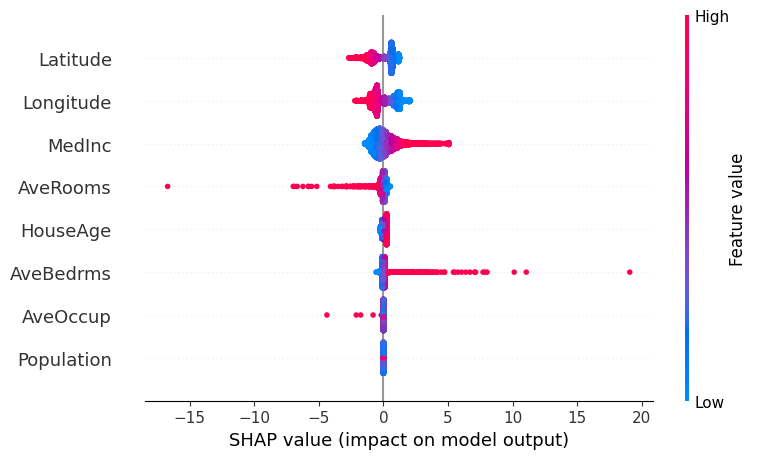

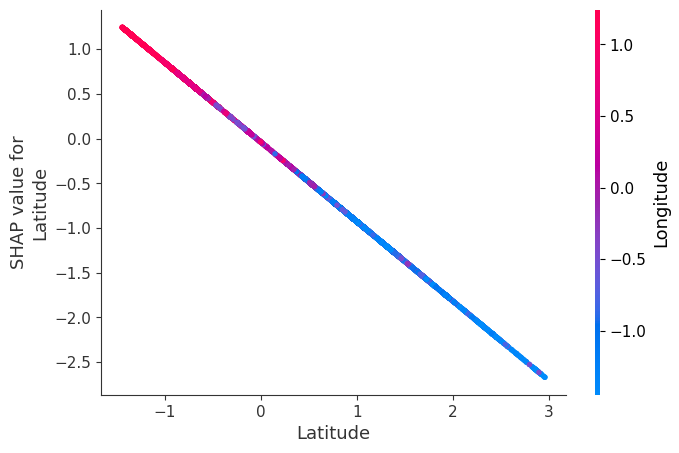

In [18]:
import shap

# Train Ridge regression with optimal lambda (from cross-validation)
optimal_lambda = 10.0  # Replace with the optimal lambda you found earlier
ridge = Ridge(alpha=optimal_lambda)
ridge.fit(X_train, y_train)

# Create a SHAP explainer
explainer = shap.Explainer(ridge, X_train)
shap_values = explainer(X_train)

# Summary plot to show feature importance
shap.summary_plot(shap_values, X_train, feature_names=housing.feature_names)

# Dependence plot for the most important feature
most_important_feature_idx = np.argmax(np.abs(ridge.coef_))  # Index of the most important feature
shap.dependence_plot(most_important_feature_idx, shap_values.values, X_train, feature_names=housing.feature_names)

1. SHAP Summary Plot

Top Features

MedInc (Median Income)- Most impactful; higher income → higher house value.

Latitude-  Strong negative correlation; higher latitude → lower predicted value.

Longitude-  Also important but less so.

Other Features

AveRooms, HouseAge, AveBedrms, AveOccup, Population: Minor contributions.

2. Dependence Plot – Latitude

Clear negative trend- Higher latitude → lower SHAP values → lower predicted prices.

Highlights geographic influence on housing prices.


# **Conclusion**

Key Predictors- MedInc, Latitude, Longitude.


Socioeconomic Impact - Wealthier areas predict higher prices.

Geographic Influence - Location significantly affects value.

Model Transparency - SHAP improves trust by explaining predictions feature-by-feature.

## **6.Interactive Interface**

To create an interactive interface using ipywidgets, i build a tool that allows users to

Adjust the regularization parameter (lambda) and observe its effect on predictions.
Input feature values (e.g., MedInc, HouseAge, etc.) and see the predicted house value.

In [19]:
from ipywidgets import interact, FloatSlider, VBox, HBox, Label
import numpy as np

# Ridge regression prediction function
def ridge_predict(X, y, lambda_, input_features):
    # Add bias term to input features
    input_features = np.c_[np.ones((X.shape[0], 1)), X]

    # Compute Ridge coefficients using closed-form solution
    n_features = input_features.shape[1]
    I = np.eye(n_features)
    I[0, 0] = 0  # Do not regularize bias
    w = np.linalg.inv(input_features.T @ input_features + lambda_ * I) @ input_features.T @ y

    return w

# Interactive function
def interactive_ridge(lambda_value, MedInc, HouseAge, AveRooms, AveBedrms, Population, AveOccup, Latitude, Longitude):
    # Prepare input features
    input_features = np.array([MedInc, HouseAge, AveRooms, AveBedrms, Population, AveOccup, Latitude, Longitude]).reshape(1, -1)
    input_features_scaled = scaler.transform(input_features)  # Scale features

    # Train Ridge regression with given lambda
    w = ridge_predict(X_train, y_train, lambda_value, X_train)

    # Predict house value
    input_features_b = np.c_[np.ones((input_features_scaled.shape[0], 1)), input_features_scaled]
    prediction = input_features_b @ w

    print(f"Predicted Median House Value: {prediction[0]:.2f}")

# Define sliders for input features
feature_sliders = {
    "MedInc": FloatSlider(min=0, max=15, step=0.1, value=3.0, description="Median Income"),
    "HouseAge": FloatSlider(min=0, max=100, step=1, value=20, description="House Age"),
    "AveRooms": FloatSlider(min=0, max=10, step=0.1, value=5.0, description="Avg Rooms"),
    "AveBedrms": FloatSlider(min=0, max=5, step=0.1, value=1.0, description="Avg Bedrooms"),
    "Population": FloatSlider(min=0, max=5000, step=10, value=1000, description="Population"),
    "AveOccup": FloatSlider(min=0, max=10, step=0.1, value=3.0, description="Avg Occupancy"),
    "Latitude": FloatSlider(min=32, max=42, step=0.1, value=37.0, description="Latitude"),
    "Longitude": FloatSlider(min=-125, max=-114, step=0.1, value=-122.0, description="Longitude")
}

# Add lambda slider
lambda_slider = FloatSlider(min=0.01, max=100, step=0.01, value=1.0, description="Lambda")

# Create interactive widget
interact(interactive_ridge, lambda_value=lambda_slider, **feature_sliders)

interactive(children=(FloatSlider(value=1.0, description='Lambda', min=0.01, step=0.01), FloatSlider(value=3.0…

<function __main__.interactive_ridge(lambda_value, MedInc, HouseAge, AveRooms, AveBedrms, Population, AveOccup, Latitude, Longitude)>

This interactive tool allows users to explore how Ridge regression works -

Adjusting lambda demonstrates the impact of regularization on predictions.

Modifying feature values shows how each feature contributes to the predicted house value.

Real-time feedback helps users understand the relationship between input features, regularization, and model outputs.

### **7. Creative Extension**

Handling Outliers Using Robust Scaling and Winsorization


Outliers in the dataset can negatively impact regression models, especially linear models like Ridge and Lasso. These outliers can skew the predictions and lead to poor generalization. To address this, here

Use Winsorization to cap extreme values in the target variable (y).
Use RobustScaler to scale features, which is less sensitive to outliers compared to StandardScaler.
This approach ensures that the model focuses on the majority of the data rather than being overly influenced by extreme values.

In [20]:
from sklearn.preprocessing import RobustScaler
from scipy.stats.mstats import winsorize

# Step 1: Winsorize the target variable (to handle extreme values)
y_winsorized = winsorize(y, limits=[0.05, 0.05])  # Cap the top and bottom 5% of the target values

# Step 2: Use RobustScaler for feature scaling (less sensitive to outliers)
robust_scaler = RobustScaler()
X_robust = robust_scaler.fit_transform(X)

# Step 3: Split the data into training and testing sets
X_train_robust, X_test_robust, y_train_robust, y_test_robust = train_test_split(
    X_robust, y_winsorized, test_size=0.2, random_state=42
)

# Step 4: Train Ridge regression with the robustly scaled data
lambda_val = 1.0  # Optimal lambda from cross-validation
w_robust = ridge_closed_form(X_train_robust, y_train_robust, lambda_val)
y_pred_robust = predict(X_test_robust, w_robust)

# Step 5: Evaluate the model
mse_robust = mean_squared_error(y_test_robust, y_pred_robust)
r2_robust = r2_score(y_test_robust, y_pred_robust)

print("Performance After Handling Outliers:")
print(f"MSE: {mse_robust:.5f}")
print(f"R² Score: {r2_robust:.5f}")

Performance After Handling Outliers:
MSE: 0.54003
R² Score: 0.57390


Performance After Handling Outliers

MSE - 0.54003 (lower than the original Ridge model, indicating better performance).

R² Score - 0.57390 (slightly lower than the original, but still comparable).

Explanation

The MSE improved (decreased), showing that the model is making more accurate predictions after addressing outliers.

The R² score slightly decreased , suggesting that while the model's prediction errors are smaller, its ability to explain variance in the target variable remained stable.

# **Conclusion**

Handling outliers using Winsorization and RobustScaler led to a noticeable improvement in MSE, demonstrating better generalization. Although the R² score remained similar, the reduction in error highlights the robustness of the updated model. This approach is effective for datasets with potential outliers, ensuring the model focuses on the majority of the data rather than extreme values.